In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## **Data Processing**

In [16]:
#Import portfolio equity data from spreadsheet in Google Drive
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQT9ZvlCv6SgOafgV_VyOVrqbn0F5O--Ihh1ZR7Gjd4quqsGAeJEGIXhdaFSGfngl4eKKPRqIDm5hpj/pub?gid=1697210824&single=true&output=csv') #last 2 year
df.head()

,Date,Pre-Holiday Effect,Fama French 5 factor,"MPT ETF allocation (SPY, QQQ, TLT, GLD)",Carry Trade with Forex,MACrossover,Risk Premia,Momentum,Market Bond Rotation,Reddit Sentiment,Tiingo News NLP
0,1546318800,97070.4781,131094.205,135836.36,31528.6258,10068.4697,91075.2399,93075.7998,100000.0000,100000.0,100000.0000
1,1546441200,97070.4781,131094.205,135834.99,31528.6258,10068.4697,90829.2114,93075.7998,100000.0000,100000.0,100000.0000
2,1546491600,98662.8771,131175.825,136169.87,32363.2585,10122.9123,90116.0109,91830.8861,99953.3565,100000.0,100000.0000
3,1546578000,97933.3140,133566.125,133827.45,32111.9930,10114.1853,90435.6803,92461.6424,100849.1154,100000.0,100000.0000
4,1546664400,97933.3140,133325.505,133827.45,31763.7904,10092.7466,90435.6803,92498.4837,99719.1453,100000.0,102179.7578


In [17]:
#converting unix timestamp into regular date format
df['Date']= pd.to_datetime(df['Date'], unit='s').dt.date
df.head()

,Date,Pre-Holiday Effect,Fama French 5 factor,"MPT ETF allocation (SPY, QQQ, TLT, GLD)",Carry Trade with Forex,MACrossover,Risk Premia,Momentum,Market Bond Rotation,Reddit Sentiment,Tiingo News NLP
0,2019-01-01,97070.4781,131094.205,135836.36,31528.6258,10068.4697,91075.2399,93075.7998,100000.0000,100000.0,100000.0000
1,2019-01-02,97070.4781,131094.205,135834.99,31528.6258,10068.4697,90829.2114,93075.7998,100000.0000,100000.0,100000.0000
2,2019-01-03,98662.8771,131175.825,136169.87,32363.2585,10122.9123,90116.0109,91830.8861,99953.3565,100000.0,100000.0000
3,2019-01-04,97933.3140,133566.125,133827.45,32111.9930,10114.1853,90435.6803,92461.6424,100849.1154,100000.0,100000.0000
4,2019-01-05,97933.3140,133325.505,133827.45,31763.7904,10092.7466,90435.6803,92498.4837,99719.1453,100000.0,102179.7578


In [18]:
#setting index to 'Date' column
df = df.set_index(pd.to_datetime(df['Date']))
df = df.drop('Date', axis=1)
df.head()

,Pre-Holiday Effect,Fama French 5 factor,"MPT ETF allocation (SPY, QQQ, TLT, GLD)",Carry Trade with Forex,MACrossover,Risk Premia,Momentum,Market Bond Rotation,Reddit Sentiment,Tiingo News NLP
Date,,,,,,,,,,
2019-01-01,97070.4781,131094.205,135836.36,31528.6258,10068.4697,91075.2399,93075.7998,100000.0000,100000.0,100000.0000
2019-01-02,97070.4781,131094.205,135834.99,31528.6258,10068.4697,90829.2114,93075.7998,100000.0000,100000.0,100000.0000
2019-01-03,98662.8771,131175.825,136169.87,32363.2585,10122.9123,90116.0109,91830.8861,99953.3565,100000.0,100000.0000
2019-01-04,97933.3140,133566.125,133827.45,32111.9930,10114.1853,90435.6803,92461.6424,100849.1154,100000.0,100000.0000
2019-01-05,97933.3140,133325.505,133827.45,31763.7904,10092.7466,90435.6803,92498.4837,99719.1453,100000.0,102179.7578


## **Co-variance Matrix of assets/strategies**



In [19]:
#Co-variance matrix
# Log of percentage change
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()

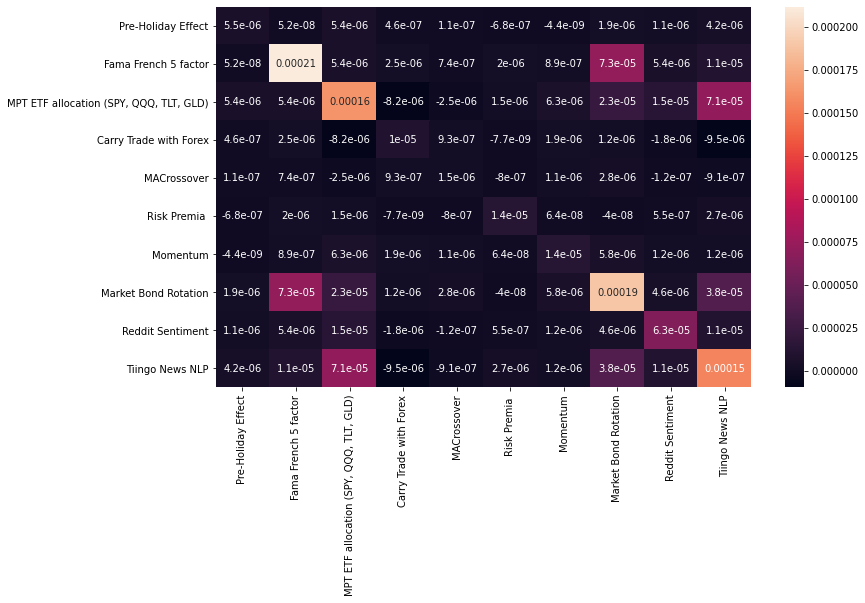

In [20]:
plt.figure(figsize=(12,7))
cov_matrix_plot = sns.heatmap(cov_matrix, annot=True)

## **Correlation Matrix of Assets/Strategies**

In [21]:
#Correlation matrix
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()

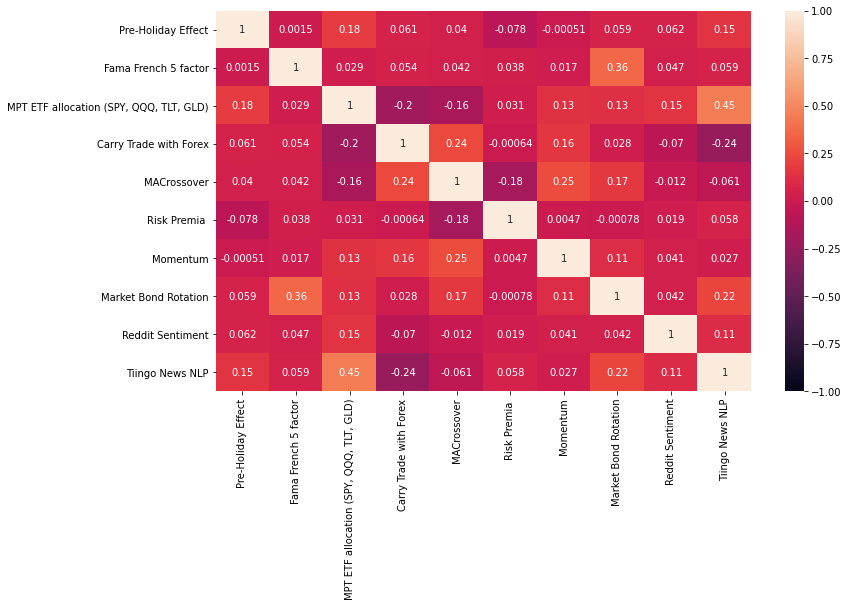

In [22]:
plt.figure(figsize=(12,7))
corr_matrix_plot = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True)

## **Annual Returns**

In [23]:
# Yearly returns for individual assets/strategies
ind_er = df.resample('Y').last().pct_change().mean() #for more than 1 year
ind_er

Pre-Holiday Effect                         0.120012
Fama French 5 factor                       0.426970
MPT ETF allocation (SPY, QQQ, TLT, GLD)    0.325569
Carry Trade with Forex                     0.085539
MACrossover                                0.035480
Risk Premia                                0.073794
Momentum                                   0.147510
Market Bond Rotation                       1.178451
Reddit Sentiment                           0.185401
Tiingo News NLP                            0.567022
dtype: float64

## **Volatility (Standard Deviation)**

In [24]:
# Converting daily standard deviation to annual standard deviation
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

Pre-Holiday Effect                         0.036998
Fama French 5 factor                       0.229962
MPT ETF allocation (SPY, QQQ, TLT, GLD)    0.201672
Carry Trade with Forex                     0.050871
MACrossover                                0.019159
Risk Premia                                0.058815
Momentum                                   0.058204
Market Bond Rotation                       0.217444
Reddit Sentiment                           0.125153
Tiingo News NLP                            0.196713
dtype: float64

## **Comparison of Returns & Volatility of Assets/Strategies**

In [25]:
# Creating a table for visualising returns and volatility of assets/strategies
assets = pd.concat([ind_er, ann_sd], axis=1) 
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
Pre-Holiday Effect,0.120012,0.036998
Fama French 5 factor,0.426970,0.229962
"MPT ETF allocation (SPY, QQQ, TLT, GLD)",0.325569,0.201672
Carry Trade with Forex,0.085539,0.050871
MACrossover,0.035480,0.019159
Risk Premia,0.073794,0.058815
Momentum,0.147510,0.058204
Market Bond Rotation,1.178451,0.217444
Reddit Sentiment,0.185401,0.125153
Tiingo News NLP,0.567022,0.196713


In [26]:
from google.colab import drive
drive.mount('/drive')
assets.to_excel('/drive/My Drive/SGUS Fintech Algo-trading BI Project/Working Folders/Phase 2 Algo-Trading/MPT/Assets.xlsx')

Mounted at /drive


## **Plotting Efficient Frontier**

In [12]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset/strategy weights

num_assets = len(df.columns)
num_portfolios = 100000 #number of portfolios to plot 

In [13]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its weights 
    p_ret.append(returns)
    
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

KeyboardInterrupt: ignored

In [ ]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [ ]:
portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the number of portfolios(num_portfolios) created

In [ ]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[12,12])
plt.xlabel('Volatility')
plt.ylabel('Returns')

## **Getting Weights for Lowest Volatility**

In [ ]:
#Getting parameter/weights of the point with minimum volatility
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

In [ ]:
assets

In [ ]:
#Sharpe Ratio of minimally volatile portfolio
sharpe_ratio_min_vol = min_vol_port[0] / min_vol_port[1]
sharpe_ratio_min_vol

In [ ]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[12,12])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)

## **Getting Weights for Highest Sharpe Ratio**

In [ ]:
# Finding the optimal portfolio (i.e. Highest Sharpe Ratio)

# risk factor(risk-free rate)
rf = 0.0161  #1.61% Average return of Singapore Savings Bonds over 10 years https://www.mas.gov.sg/bonds-and-bills/Singapore-Savings-Bonds

optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

In [ ]:
assets

In [ ]:
#Sharpe Ratio of Optimally risky portfolio
sharpe_ratio_risky = optimal_risky_port[0] / optimal_risky_port[1]
sharpe_ratio_risky

In [ ]:
# Plotting optimal portfolio (Blue Star)
plt.subplots(figsize=(12, 12))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='b', marker='*', s=500)

In [ ]:
from google.colab import drive
drive.mount('/drive')
portfolios.to_excel('/drive/My Drive/SGUS Fintech Algo-trading BI Project/Working Folders/Phase 2 Algo-Trading/MPT/MPT Python SGUS Project 2 year random weights Optimized High-Low Risk.xlsx')